In [1]:
import sys
import os
from numpy.fft import rfft2, irfft2

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from HOSim.solver import rk4_step, f2d

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

In [2]:
modes = 64
mHOS = 8
tMax = 200
step_size = 0.025
output_interval = 5
harmonics = 8

A = 0.1
k = 1
g = 1
Ta = 8*2*np.pi/np.sqrt(g)

eta_hat_0 = np.zeros((2*modes, modes+1), dtype=complex)
phi_hat_0 = np.zeros((2*modes, modes+1), dtype=complex)

eta_hat_0[1, 1] = A * modes * modes * 2
phi_hat_0[1, 1] = -1.j * A * np.sqrt(g/k) * modes * modes * 2

y = np.stack([eta_hat_0, phi_hat_0])
k0 = 1/np.sqrt(2)

steps = int(np.ceil(tMax / step_size))

f_jit = jax.jit(f2d, static_argnums=(2, 3, 4, 5, 6))
rk4_step_jit = jax.jit(rk4_step, static_argnums=(2, 3, 4, 5, 6, 7, 8))

result = np.zeros((steps // output_interval+1, harmonics+1, harmonics+1), dtype=complex)
result[0] = y[0, :harmonics+1, :harmonics+1]

t = 0
for i in range(1, steps+1):
    if i % output_interval == 0:
        result[i // output_interval] = y[0, :harmonics+1, :harmonics+1]
        print(f"{i/steps*100:.2f}%")

    y = rk4_step_jit(t, y, step_size, modes, g, k0, mHOS, Ta, f_jit)
    t += step_size

0.06%
0.12%
0.19%
0.25%
0.31%
0.38%
0.44%
0.50%
0.56%
0.62%
0.69%
0.75%
0.81%
0.88%
0.94%
1.00%
1.06%
1.12%
1.19%
1.25%
1.31%
1.38%
1.44%
1.50%
1.56%
1.62%
1.69%
1.75%
1.81%
1.88%
1.94%
2.00%
2.06%
2.12%
2.19%
2.25%
2.31%
2.38%
2.44%
2.50%
2.56%
2.62%
2.69%
2.75%
2.81%
2.88%
2.94%
3.00%
3.06%
3.12%
3.19%
3.25%
3.31%
3.38%
3.44%
3.50%
3.56%
3.62%
3.69%
3.75%
3.81%
3.88%
3.94%
4.00%
4.06%
4.12%
4.19%
4.25%
4.31%
4.38%
4.44%
4.50%
4.56%
4.62%
4.69%
4.75%
4.81%
4.88%
4.94%
5.00%
5.06%
5.12%
5.19%
5.25%
5.31%
5.38%
5.44%
5.50%
5.56%
5.62%
5.69%
5.75%
5.81%
5.88%
5.94%
6.00%
6.06%
6.12%
6.19%
6.25%
6.31%
6.38%
6.44%
6.50%
6.56%
6.62%
6.69%
6.75%
6.81%
6.88%
6.94%
7.00%
7.06%
7.12%
7.19%
7.25%
7.31%
7.38%
7.44%
7.50%
7.56%
7.62%
7.69%
7.75%
7.81%
7.88%
7.94%
8.00%
8.06%
8.12%
8.19%
8.25%
8.31%
8.38%
8.44%
8.50%
8.56%
8.62%
8.69%
8.75%
8.81%
8.88%
8.94%
9.00%
9.06%
9.12%
9.19%
9.25%
9.31%
9.38%
9.44%
9.50%
9.56%
9.62%
9.69%
9.75%
9.81%
9.88%
9.94%
10.00%
10.06%
10.12%
10.19%
10.25%
10.31%
10.3

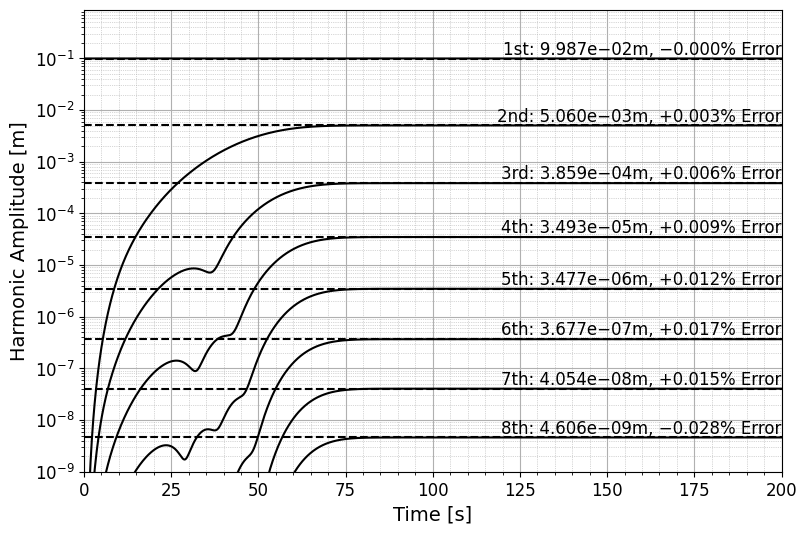

In [8]:
def ordinal(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

fontsize = 12

amps = np.array([9.9870520E-02, 5.0594125E-03, 3.8584235E-04, 3.4929691E-05, 3.4769679E-06, 3.6763951E-07, 4.0531740E-08, 4.6076934E-09])

fig, ax = plt.subplots(figsize=(9, 6))
for i in range(harmonics):
    modal_result = abs(result[-1, i+1, i+1]) / modes / modes / 2
    modal_error = (modal_result - amps[i]) / modal_result * 100
    plt.semilogy(np.linspace(0, tMax, result.shape[0]), abs(result[:, i+1, i+1]) / modes / modes / 2, color="k", label=f"Harmonic {i+1}: {modal_result:.3e}m, {modal_error:.3f}% Error")
    plt.axhline(y=amps[i], color="k", linestyle="--")
    ax.annotate(f"{ordinal(i+1)}: {modal_result:.3e}m, {modal_error:+1.3f}% Error".replace("-", "−"),
                xy=(tMax, modal_result),         # Point to annotate
                xytext=(tMax, modal_result),     # Text location
                # arrowprops=dict(arrowstyle='-'),
                va='bottom',
                ha='right',
                fontsize=fontsize)

plt.xlim(0, tMax)
plt.ylim(10.0E-10)
plt.ylabel("Harmonic Amplitude [m]", fontsize=fontsize+2)
plt.xlabel("Time [s]", fontsize=fontsize+2)
ax.grid(True, which='major', linewidth=0.8)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.tick_params(labelsize=12)
plt.savefig("results/verification_2d.pdf", dpi=300, bbox_inches='tight')
plt.show()